In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx

import src
from src.reload import deep_reload

In [2]:
gdf_zones = gpd.read_file('Data/NGOD/Shapes/V2_Zones.shp')

gdf_zones['in_california'] = gdf_zones['V2ZONEID'].apply(lambda zid: 'CA' in zid)

gdf_zones_california = gdf_zones[gdf_zones['in_california']]

gdf_zones_california = gdf_zones_california.explode(drop = True)

In [3]:
filename = 'cities.json'

graph_cities = src.graph.graph_from_json(filename)

In [4]:
# Graph containing DC chargers

with open('Data/AFDC/evse_stations.json', 'r') as file:
    evse = json.load(file)

In [5]:
stations_raw = []

for station in evse['fuel_stations']:

    checks = (
        station['state'] == 'CA',
        station['ev_dc_fast_num'] is not None,
        station['access_code'] == 'public',
        station['status_code'] == 'E',
        
    )

    if all(checks):

        stations_raw.append(station)

In [6]:
df_stations = pd.DataFrame.from_dict(stations_raw)

In [7]:
node_attributes = {
    'x': 'lambda n: n["longitude"]',
    'y': 'lambda n: n["latitude"]',
    'n_dcfc': 'lambda n: n["ev_dc_fast_num"]',
    'n_acl2': 'lambda n: n["ev_level2_evse_num"]',
    'network': 'lambda n: n["ev_network"]',
    'name': 'lambda n: n["station_name"]',
    'address': 'lambda n: n["street_address"]',
    'city': 'lambda n: n["city"]',
    'state': 'lambda n: n["state"]',
    'zip': 'lambda n: n["zip"]',
    'access_code': 'lambda n: n["access_code"]',
    'status_code': 'lambda n: n["status_code"]',
    'type': 'lambda n: "station"',
}

nlg = src.graph.nlg_from_dataframe(df_stations, node_attributes)

graph_station = src.graph.graph_from_nlg(nlg)

mapping = {n: f'station_{n}' for n in graph_station.nodes}

graph_station = nx.relabel_nodes(graph_station, mapping)

In [46]:
graph = nx.union(graph_cities, graph_station)

In [34]:
atlas = src.graph.graph_from_json('atlas_california.json')

In [35]:
atlas._adj[0][1]

{'distance': 450.0, 'speed': 17.77777777777778, 'time': 25.3125}

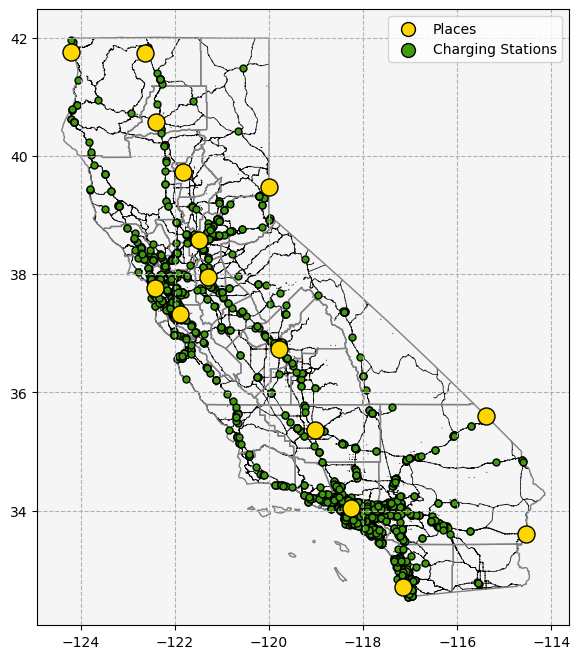

In [10]:
deep_reload(src)

fig, ax = plt.subplots(1, 1, figsize = (8, 8), squeeze = False)

kwargs = {
		# 'node_field': 'type_num',
		'scatter': {
			's': 150,
			'ec': 'k',
            'fc': 'gold',
            'label': 'Places',
            'zorder': 2,
		},
		'show_links': False,
	}

gdf_zones_california.plot(ax = ax[0, 0], ec = 'gray', fc = 'none')
src.figures.plot_graph(graph_cities, ax = ax[0, 0], **kwargs)
ax[0, 0].legend()
ax[0, 0].grid(ls = '--')

kwargs = {
		'node_field': None,
		'scatter': {
			's': .5,
			'ec': 'none',
            'fc': 'k',
            # 'label': 'Roads',
            'zorder': 0,
		},
		'show_links': False,
	}

# gdf_zones_california.plot(ax = ax[1], ec = 'gray', fc = 'none')
src.figures.plot_graph(atlas, ax = ax[0, 0], **kwargs)
ax[0, 0].legend(markerscale = 10)
ax[0, 0].grid(ls = '--')

kwargs = {
		# 'node_field': 'type_num',
		'scatter': {
			's': 25,
			'ec': 'k',
            'fc': 'xkcd:grass green',
            'label': 'Charging Stations',
            'zorder': 1,
		},
		'show_links': False,
        'axes': {
            'facecolor': 'whitesmoke',
        }
	}

# gdf_zones_california.plot(ax = ax[2], ec = 'gray', fc = 'none')
src.figures.plot_graph(graph_station, ax = ax[0, 0], **kwargs)
legend = ax[0, 0].legend()
legend.legendHandles[0]._sizes = [100]
# legend.legendHandles[1]._sizes = [120]
legend.legendHandles[1]._sizes = [100]
ax[0, 0].grid(ls = '--')

# fig.savefig('Document/figs/California_Places_Chargers', bbox_inches = 'tight', dpi = 300)

In [47]:
deep_reload(src)

graph_to_atlas, atlas_to_graph = src.graph.graph_to_atlas(graph, atlas)

In [82]:
atlas.number_of_nodes(), atlas.number_of_edges()

(59621, 63677)

In [83]:
deep_reload(src)

veh = src.routing.Vehicle(n_cases = 1, cutoff = 400e3)

t0 = time.time()

# all_pairs_expectations = veh.all_pairs(
#     atlas,
#     nodes = [key for key in atlas_to_graph.keys()],
#     # progress_bar = {'disp': True, 'freq': 10}
# )

time.time() - t0

2.0503997802734375e-05

In [73]:
deep_reload(src)

weights = {
    "distance": 400e3,
    "time": np.inf
}

t0 = time.time()

ng = src.adjacency.adjacency(atlas, graph, weights, compute_all = True)

time.time() - t0

3.218650817871094e-05

In [26]:
gdf = gpd.read_file('../Atlas_Source/North_American_Roads.shp')

In [27]:
gdf_select = gdf[(
    (gdf['JURISNAME'] == 'California')
    # ((gdf['JURISNAME'] == 'Nevada') & (gdf['ROADNUM'] == 'I15'))|
    # ((gdf['JURISNAME'] == 'Arizona') & (gdf['ROADNUM'] == 'I10'))
)]

gdf_select = gdf_select.to_crs(4326)

In [28]:
graph = src.graph.graph_from_gdf(gdf_select)

In [29]:
node_attributes = {}
link_attributes=  {
    "distance": "lambda e: e['LENGTH']*1e3",
    "speed": "lambda e: e['SPEEDLIM']/3.6",
    "time": "lambda e: (e['LENGTH']*1e3)/(e['SPEEDLIM']/3.6)"
}

In [30]:
deep_reload(src)

graph = src.graph.reformat_graph(
    graph, node_attributes, link_attributes)

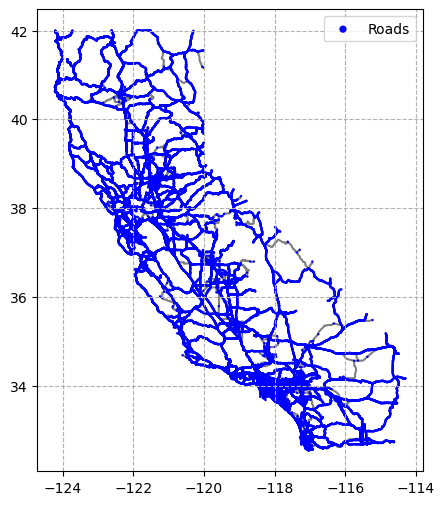

In [31]:
deep_reload(src)

fig, ax = plt.subplots(1, 1, figsize = (6, 6), squeeze = False)

kwargs = {
		'node_field': None,
		'scatter': {
			's': 3,
			'ec': 'none',
            'fc': 'b',
            'label': 'Roads',
		},
		'show_links': False,
	}

gdf_select.plot(ax = ax[0, 0], ec = 'gray', fc = 'none', zorder = 0)
src.figures.plot_graph(graph, ax = ax[0, 0], **kwargs)
ax[0, 0].legend(markerscale = 3)
ax[0, 0].grid(ls = '--')

# fig.savefig('Document/figs/California_Places_Chargers', bbox_inches = 'tight', dpi = 300)

In [32]:
src.graph.graph_to_json(graph, 'atlas_california.json')